# DCGAN(심층 합성곱 GAN)

# 라이브러리 import

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Activation, BatchNormalization, Dense, Dropout, Flatten, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [ ]:
img_rows = 28
img_columns = 28
channels = 1

# 입력이미지 차원
img_shape = (img_rows, img_columns, channels)

# 생성자 입력으로 사용될 노이즈 벡터의 크기
z_dim = 100

# Generator(생성자)
- Conv2DTranspose 층을 사용하여 너비와 높이는 늘리되, 깊이는 줄일 수 있다.

In [ ]:
def build_generator(z_dim):
  model = Sequential()

  # 완전 연결층을 통해 입력을 7x7x256 크기의 텐서로 변환한다.
  model.add(Dense(256 * 7 * 7, input_dim = z_dim))
  model.add(Reshape((7, 7, 256)))

  # 7x7x256에서 14x14x128 텐서로 바꾸는 전치 합성곱 층을 생성
  # 각 Conv2DTranspose 층 다음에는 BatchNormalization과 LeakyReLU를 사용한다.
  model.add(Conv2DTranspose(128, kernel_size=3, strides=2, padding='same'))
  # BatchNormalization 하기
  model.add(BatchNormalization())
  # LeakyReLU 활성화 함수 사용하기
  model.add(LeakyReLU(alpha=0.01))
  # 14x14x128에서 14x14x64 텐서로 바꾸는 전치 합성곱 층
  # 너비와 높이 차원을 바꾸지 않고 깊이만 바꾸려면 strides = 1로 지정한다.
  model.add(Conv2DTranspose(64, kernel_size=3, strides=1, padding='same'))
  

  # BatchNormalization 하기
  model.add(BatchNormalization())
  # LeakyReLU 활성화 함수 사용하기
  model.add(LeakyReLU(alpha=0.01))
  # 14x14x64에서 28x28x1 텐서로 바꾸는 전치 합성곱 층
  model.add(Conv2DTranspose(1, kernel_size=3, strides=2, padding='same'))

  # tanh 활성화 함수를 사용한 출력층
  model.add(Activation('tanh'))

  return model


# Discriminator(판별자)
1. 합성곱 층을 사용해 28x28x1 입력 이미지를 14x14x32 크기의 텐서로 변환
2. LeakyReLU 활성화 함수를 사용
3. 합성곱 층을 사용해 14x14x32 입력 이미지를 7x7x64 크기의 텐서로 변환
4. LeakyReLU 활성화 함수를 사용
5. 합성곱 층을 사용해 7x7x64 입력 이미지를 3x3x128 크기의 텐서로 변환
6. LeakyReLU 활성화 함수를 사용
7. 3x3x128 크기의 텐서를 3x3x128x1152 크기의 벡터로 펼친다.

In [ ]:
def build_discriminator(img_shape):
  model = Sequential()

  # 28x28x1 텐서에서 14x14x32 크기의 텐서로 바꾸는 합성곱 층
  model.add(
      Conv2D(32, 
             kernel_size=3, 
             strides=2,
             input_shape=img_shape, 
             padding='same'))
  model.add(LeakyReLU(alpha=0.01))

  # 14x14x32 텐서에서 7x7x64 크기의 텐서로 바꾸는 합성곱 층
  model.add(
      Conv2D(64,
             kernel_size=3,
             strides=2,
             padding='same'))
  model.add(LeakyReLU(alpha=0.01))

  # 7x7x64 텐서에서 3x3x128 크기의 텐서로 바꾸는 합성곱 층
  model.add(
      Conv2D(128,
             kernel_size=3,
             strides=2,
             padding='same'))
  model.add(LeakyReLU(alpha=0.01))

  # 시그모이드 활성화 함수를 사용한 출력층
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))

  return model

# 모델 만들기

In [ ]:
def build_gan(generator, discriminator):
  model = Sequential()

  # 생성자 + 판별자 모델 연결
  model.add(generator)
  model.add(discriminator)

  return model

In [ ]:
# 판별자 모델을 만들고 컴파일하기
discriminator = build_discriminator(img_shape)
discriminator.compile(loss='binary_crossentropy',
                      optimizer=Adam(),
                      metrics=['accuracy'])

# 생성자 모델 만들기
generator = build_generator(z_dim)

# 생성자를 훈련하는 동안 판별자의 파라미터를 유지함
discriminator.trainable = False

# 생성자를 훈련하기 위해 동결된 판별자로 GAN 모델을 만들고 컴파일
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy',
            optimizer=Adam())

# 훈련

In [ ]:
losses = []
accuracies = []
iteration_checkpoints = []

def train(iterations, batch_size, sample_interval):

  # MNIST 데이터 셋 로드하기
  (X_train, _),(_, _) = mnist.load_data()

  # [0, 255] 흑백 픽셀 값을 [-1, 1] 사이로 스케일 조정하기
  X_train = X_train / 127.5 -1.0
  X_train = np.expand_dims(X_train, axis=3)

  # 진짜 이미지 레이블: 모두 1
  real = np.ones((batch_size, 1))

  # 가짜 이미지 레이블: 모두 0
  fake = np.zeros((batch_size, 1))

  for iteration in range(iterations):
    # -------------------------
    #  판별자 훈련
    # -------------------------
    
    # 진짜 이미지에서 랜덤 배치 가져오기
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]

    # 가짜 이미지 배치 생성
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # 판별자 훈련
    d_loss_real = discriminator.train_on_batch(imgs, real)
    d_loss_fake = discriminator.train_on_batch(gen_imgs, fake)
    d_loss, accuracy = 0.5 * np.add(d_loss_real, d_loss_fake)

    # ---------------------
    #  생성자 훈련
    # ---------------------    

    # 가짜 이미지 배치 생성
    z = np.random.normal(0, 1, (batch_size, 100))
    gen_imgs = generator.predict(z)

    # 생성자 훈련
    g_loss = gan.train_on_batch(z, real)

    if (iteration + 1) % sample_interval == 0:

      # 훈련이 끝난 후 그래프를 그리기 위해 손실과 정확도 저장
      losses.append((d_loss, g_loss))
      accuracies.append(100.0 * accuracy)
      iteration_checkpoints.append(iteration + 1)

      # 훈련 과정 출력
      print(f"{iteration + 1} [D 손실값: {d_loss}, 정확도: {100.0 * accuracy : .2f}, G 손실값: {g_loss}]")

      # 생성된 이미지 샘플 출력
      sample_images(generator)
    

In [ ]:
def sample_images(generator, image_grid_rows = 4, image_grid_columns= 4):

  # 랜덤한 잡은 샘플링
  z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

  # 랜덤한 잡음에서 이미지 생성하기
  gen_imgs = generator.predict(z)

  # 이미지 픽셀 값을 [0, 1] 사이로 스케일 조정
  gen_imgs = 0.5 * gen_imgs + 0.5

  # 이미지 그리드 설정
  fig, axs = plt.subplots(image_grid_rows,
                          image_grid_columns,
                          figsize=(4, 4),
                          sharey = True,
                          sharex = True)
  
  cnt = 0

  for i in range(image_grid_rows):
    for j in range(image_grid_columns):
      # 이미지 그리드 출력
      axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      cnt += 1
  plt.show()



# GAN 훈련과 출력 점검

1000 [D 손실값: 0.4005250185728073, 정확도:  83.20, G 손실값: 1.4992544651031494]


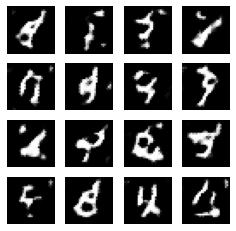

2000 [D 손실값: 0.6165165603160858, 정확도:  69.14, G 손실값: 1.1146888732910156]


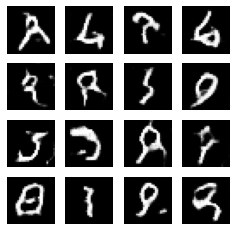

3000 [D 손실값: 0.5436146855354309, 정확도:  69.92, G 손실값: 1.5412694215774536]


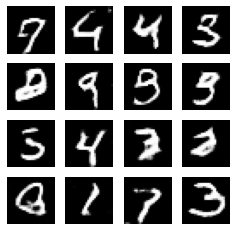

4000 [D 손실값: 0.42490150034427643, 정확도:  83.20, G 손실값: 1.7897316217422485]


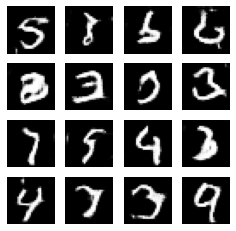

5000 [D 손실값: 0.4126095324754715, 정확도:  82.42, G 손실값: 1.5949909687042236]


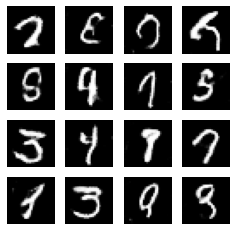

6000 [D 손실값: 0.4815608561038971, 정확도:  77.34, G 손실값: 1.5950769186019897]


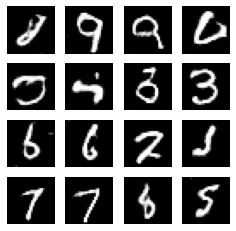

7000 [D 손실값: 0.47999419271945953, 정확도:  75.00, G 손실값: 2.0026190280914307]


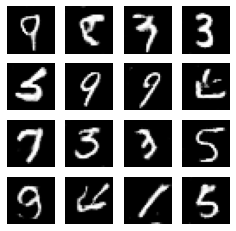

8000 [D 손실값: 0.3684319406747818, 정확도:  83.59, G 손실값: 1.7913000583648682]


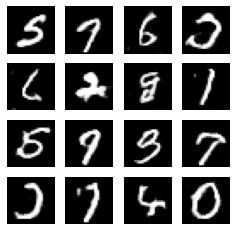

9000 [D 손실값: 0.39876532554626465, 정확도:  83.59, G 손실값: 2.1281938552856445]


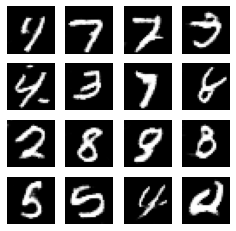

10000 [D 손실값: 0.3934088796377182, 정확도:  82.03, G 손실값: 2.2109410762786865]


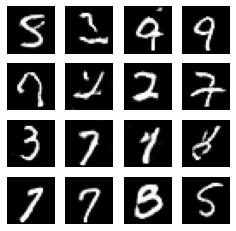

In [ ]:
# 하이퍼파라미터 설정
iterations = 10000
batch_size = 128
sample_interval = 1000

# 지정된 반복 횟수만큼 DCGAN 훈련하기
train(iterations, batch_size, sample_interval)

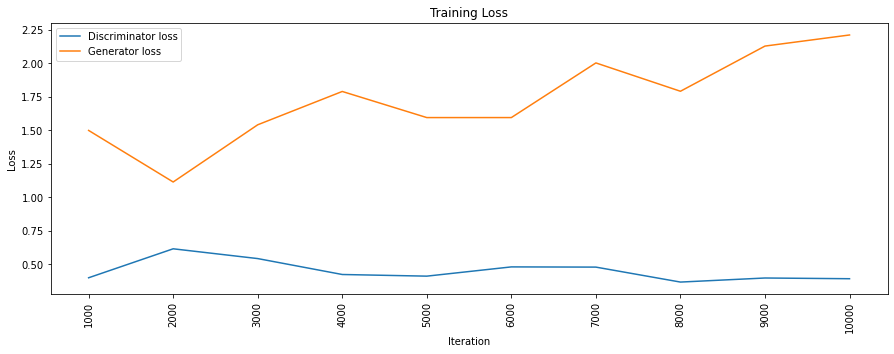

In [ ]:
losses = np.array(losses)

# 판별자와 생성자의 훈련 손실 그래프
plt.figure(figsize= (15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label='Discriminator loss')
plt.plot(iteration_checkpoints, losses.T[1], label='Generator loss')

plt.xticks(iteration_checkpoints, rotation= 90)

plt.title("Training Loss")
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.show()

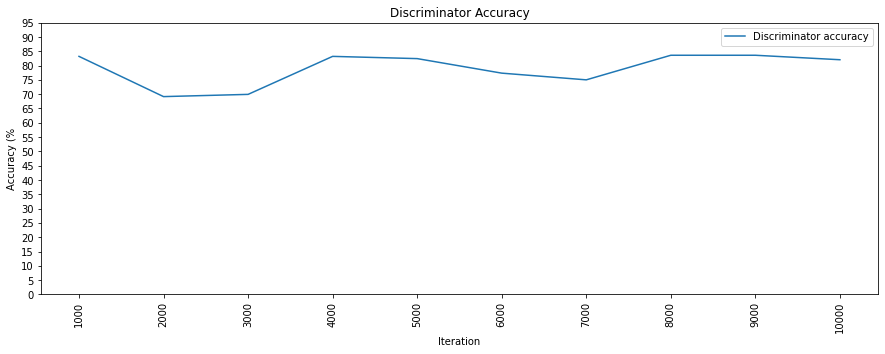

In [ ]:
accuracies = np.array(accuracies)

# 판별자의 정확도 그래프
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, accuracies, label='Discriminator accuracy')

plt.xticks(iteration_checkpoints, rotation= 90)
plt.yticks(range(0, 100, 5))

plt.title('Discriminator Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy (%')
plt.legend()
plt.show()
